In [1]:
import jax
import jax.numpy as jnp
from arraytainers import Jaxtainer
from approx_post.distributions import approx, joint, mixture
from approx_post import losses, optimisers
import seaborn as sns
import matplotlib.pyplot as plt
sns.set({'figure.facecolor':'white', "figure.figsize":(10,7)})

In [2]:
def create_data(model, true_theta, noise_cov, num_samples, ndim, prngkey):
    mean = model(true_theta)
    samples = jax.random.multivariate_normal(key=prngkey, mean=mean, cov=noise_cov, shape=(num_samples,))
    return samples.reshape(num_samples, -1)

In [3]:
# First, let's define a model:
ndim = 1
model = lambda theta: theta**2
model_grad = jax.vmap(jax.vmap(jax.jacfwd(model), in_axes=0), in_axes=0)

In [4]:
# Create artificial data:
prngkey = jax.random.PRNGKey(10)
true_theta = jnp.array([2])
noise_cov = 1*jnp.identity(ndim)
num_samples = 1
data = create_data(model, true_theta, noise_cov, num_samples, ndim, prngkey)
print(f'True theta: \n {true_theta}')
print(f'True x = model(theta): \n {model(true_theta)}')
print(f'Observations x_obs = model(theta) + noise: \n {data}')

True theta: 
 [2]
True x = model(theta): 
 [4]
Observations x_obs = model(theta) + noise: 
 [[2.6554594]]


In [11]:
# Create Joint distribution from forward model:
prior_mean = jnp.zeros(ndim)
prior_cov = 1.*jnp.identity(ndim)
joint_dist = joint.ModelPlusGaussian(model, noise_cov, prior_mean, prior_cov, model_grad)

In [13]:
approx_dist = approx.Gaussian(ndim)
prngkey = jax.random.PRNGKey(12)
loss = losses.ELBO(joint_dist, use_reparameterisation=False)
optimiser = optimisers.Adam()
optimiser.fit(approx_dist, loss, data, prngkey, verbose=True, max_iter=100, num_samples=1000)

Loss = 3.406830310821533, Params = Jaxtainer({'mean': DeviceArray([-0.1], dtype=float32), 'log_chol_diag': DeviceArray([-0.1], dtype=float32)})
Loss = 3.244300603866577, Params = Jaxtainer({'mean': DeviceArray([-0.19056298], dtype=float32), 'log_chol_diag': DeviceArray([-0.17658246], dtype=float32)})
Loss = 3.2362217903137207, Params = Jaxtainer({'mean': DeviceArray([-0.2728338], dtype=float32), 'log_chol_diag': DeviceArray([-0.22078103], dtype=float32)})
Loss = 3.254183769226074, Params = Jaxtainer({'mean': DeviceArray([-0.35025868], dtype=float32), 'log_chol_diag': DeviceArray([-0.23751678], dtype=float32)})
Loss = 3.258932113647461, Params = Jaxtainer({'mean': DeviceArray([-0.42453644], dtype=float32), 'log_chol_diag': DeviceArray([-0.23523393], dtype=float32)})
Loss = 3.25388240814209, Params = Jaxtainer({'mean': DeviceArray([-0.4946965], dtype=float32), 'log_chol_diag': DeviceArray([-0.22148073], dtype=float32)})
Loss = 3.2527692317962646, Params = Jaxtainer({'mean': DeviceArray([

Loss = 3.2300641536712646, Params = Jaxtainer({'mean': DeviceArray([-0.31673822], dtype=float32), 'log_chol_diag': DeviceArray([-0.12991098], dtype=float32)})
Loss = 3.2285685539245605, Params = Jaxtainer({'mean': DeviceArray([-0.31666434], dtype=float32), 'log_chol_diag': DeviceArray([-0.13371235], dtype=float32)})
Loss = 3.227780818939209, Params = Jaxtainer({'mean': DeviceArray([-0.31837285], dtype=float32), 'log_chol_diag': DeviceArray([-0.13553408], dtype=float32)})
Loss = 3.2276411056518555, Params = Jaxtainer({'mean': DeviceArray([-0.32172778], dtype=float32), 'log_chol_diag': DeviceArray([-0.13517159], dtype=float32)})
Loss = 3.228057384490967, Params = Jaxtainer({'mean': DeviceArray([-0.32627708], dtype=float32), 'log_chol_diag': DeviceArray([-0.13299397], dtype=float32)})
Loss = 3.2290022373199463, Params = Jaxtainer({'mean': DeviceArray([-0.3313291], dtype=float32), 'log_chol_diag': DeviceArray([-0.12980871], dtype=float32)})
Loss = 3.23040509223938, Params = Jaxtainer({'mea

In [57]:
approx_dist = approx.Gaussian(ndim)
# mix_dist = mixture.Different([approx_dist, approx_dist])
mix_dist = mixture.Identical(approx_dist,1)

In [67]:
epsilon = approx_dist.sample_base(1000, prngkey) #jnp.array([-1., 0., -2.]).reshape(-1,1)

In [68]:
theta = approx_dist.transform(epsilon)
transform_del_phi = approx_dist.transform_del_2(epsilon)
approx_del_1 = approx_dist.logpdf_del_1(theta) 
print(np.mean(np.einsum("abj,abj...->ab...", approx_del_1, transform_del_phi)))
print(np.mean(approx_dist.logpdf_del_2(theta)))

Jaxtainer({'log_chol_diag': DeviceArray(-1.0961872, dtype=float32), 'mean': DeviceArray(-0.02752675, dtype=float32)})
Jaxtainer({'log_chol_diag': DeviceArray(0.09618708, dtype=float32), 'mean': DeviceArray(0.02752675, dtype=float32)})


In [60]:
theta = mix_dist.transform(epsilon[:,None])
mix_dist.logpdf_del_2(theta)

Jaxtainer({'component_0': {'log_chol_diag': DeviceArray([[[-0.49979138],
              [-0.573161  ],
              [-0.9992139 ],
              [ 3.3286781 ],
              [-0.5784723 ]]], dtype=float32), 'mean': DeviceArray([[[-0.7072543 ],
              [ 0.6533292 ],
              [ 0.02803834],
              [-2.0805476 ],
              [ 0.64925164]]], dtype=float32)}, 'log_unnorm_coeff': DeviceArray([[[0.],
              [0.],
              [0.],
              [0.],
              [0.]]], dtype=float32)})

In [7]:
approx_dist = approx.Gaussian(ndim)
# mix_dist = mixture.Different([approx_dist, approx_dist])
mix_dist = mixture.Identical(approx_dist,1)

prngkey = jax.random.PRNGKey(12)
loss = losses.SELBO(joint_dist, use_reparameterisation=True)
optimiser = optimisers.Adam()
optimiser.fit(mix_dist, loss, data, prngkey, verbose=True, max_iter=100, num_samples=5)

Jaxtainer({'component_0': {'log_chol_diag': DeviceArray([[[[-1.]],

              [[-1.]],

              [[-1.]],

              [[-1.]],

              [[-1.]]]], dtype=float32), 'mean': DeviceArray([[[[0.]],

              [[0.]],

              [[0.]],

              [[0.]],

              [[0.]]]], dtype=float32)}, 'log_unnorm_coeff': DeviceArray([[[[0.]],

              [[0.]],

              [[0.]],

              [[0.]],

              [[0.]]]], dtype=float32)})
Jaxtainer({'component_0': {'log_chol_diag': DeviceArray([[[[-2.8459361e+00]],

              [[-2.3658662e+00]],

              [[-3.6875512e-03]],

              [[-5.7772434e+01]],

              [[-2.3319488e+00]]]], dtype=float32), 'mean': DeviceArray([[[[ 4.023922  ]],

              [[-3.6212468 ]],

              [[-0.13151816]],

              [[27.767899  ]],

              [[-3.5917487 ]]]], dtype=float32)}, 'log_unnorm_coeff': DeviceArray([[[[ 0.]],

              [[-0.]],

              [[-0.]],

           

KeyboardInterrupt: 

In [7]:
mix_dist.add_component()

In [ ]:
def filter(grad):
    for i in range(1):
        grad[f'component_{i}'] = 0*grad[f'component_{i}']
    grad['log_unnorm_coeff'] = 0*grad['log_unnorm_coeff']
    return grad

perturbation = {'component_0': 0., 
                'component_1': Jaxtainer({'mean':0.5, 'log_chol_diag': -0.1}) , 
                'log_unnorm_coeff': 0.}
mix_dist.perturb(perturbation)

optimiser.fit(mix_dist, loss, data, prngkey, grad_filter=filter, verbose = True, max_iter=100, num_samples=1000)

In [ ]:
def filter(grad):
    for i in range(2):
        grad[f'component_{i}'] = 0*grad[f'component_{i}']
    return grad

optimiser.fit(mix_dist, loss, data, prngkey, grad_filter=filter, verbose = True, max_iter=100, num_samples=1000)

In [14]:
def plot_posteriors(approx_dist, theta=None):
    if theta is None:
        theta = jnp.atleast_2d(jnp.linspace(-3, 3, 5000)).reshape(1,-1,1)
    pdf = jnp.exp(approx_dist.logpdf(theta))
    ax = sns.lineplot(x=theta.squeeze(), y=pdf.squeeze())
    ax.fill_between(theta.squeeze(), pdf.squeeze(), alpha=0.2)
    plt.xlabel("Parameter $\Theta$")
    plt.ylabel("Posterior Probability Density")

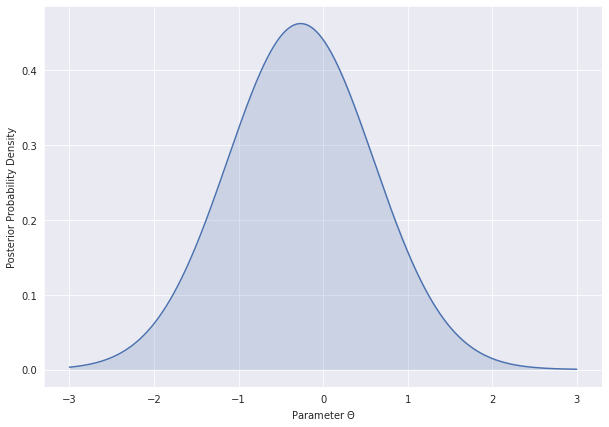

In [15]:
plot_posteriors(approx_dist)

In [12]:
mix_dist.phi()

Jaxtainer({'component_0': {'mean': DeviceArray([[-8.743457e-05]], dtype=float32), 'log_chol_diag': DeviceArray([[-3.7792566]], dtype=float32)}, 'component_1': {'mean': DeviceArray([[0.]], dtype=float32), 'log_chol_diag': DeviceArray([[0.]], dtype=float32)}, 'log_unnorm_coeff': DeviceArray([[0., 0.]], dtype=float32)})